The final budget of the trading strategy is 209861 USD
Total number of trades is 30


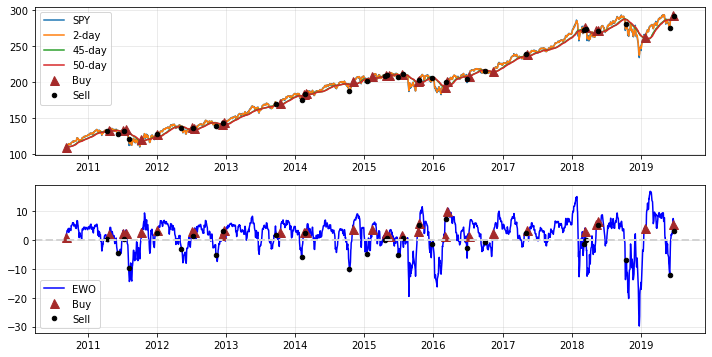

In [4]:
#3.2 EWO Revision 1 with the Best Combination
#EWO = Elliott Wave Oscillator
#The current code only focuses on the long position

import import_ipynb
import EWO

#Dataframe Initialization
#target_market_ticker = EWO.Ewo(target_market_ticker, start_date(yyyy-mm-dd), end_date(yyyy-mm-dd))
SPY = EWO.Ewo('SPY', '2010-06-28', '2019-06-28')

#Process data and return market & market_buy_init dataframes
#market, market_buy_init = target_market_ticker.data_process(fast_sma, slow_sma, \
#longer_sma, n_day_EWO_slope, n_day_closing_price, use_filter4(0 or 1))
market, market_buy_init = SPY.data_process(2, 45, 50, 5, 50, 0)

#Backtesting of trading strategy on the target_market_ticker from start_date to end_date
#print the final budget and total number of trades & return market_buy and market_sell dataframes
#market_buy, market_sell = target_market_ticker.backtest(budget, market, market_buy_init)
market_buy, market_sell = SPY.backtest(100000, market, market_buy_init)

#Visualize the trading result with graphs for price trend and the EWO value
#target_market_ticker.visualize(market, market_buy, market_sell)
SPY.visualize(market, market_buy, market_sell)

In [5]:
market_buy.head()

,Date,Open,Close,2-day,45-day,50-day,EWO,Filter1,Filter2,Filter3,Exit1,Exit2
Day,,,,,,,,,,,,
51,2010-09-08,109.860001,110.410004,110.025002,109.114223,108.508000,0.910779,0,1,1,0,0
209,2011-04-25,133.679993,133.639999,133.709999,131.542444,131.741200,2.167555,1,1,1,0,-1
259,2011-07-06,133.490005,133.970001,133.889999,131.511999,131.945199,2.378001,1,1,1,0,-1
270,2011-07-21,133.399994,134.490005,133.570000,131.049554,131.342999,2.520446,1,1,1,0,-1
328,2011-10-12,120.599998,120.750000,120.224998,117.329778,117.521800,2.895221,1,1,1,0,-1


In [6]:
market_sell.head()

,Date,Open,Close,2-day,45-day,50-day,EWO,Filter1,Filter2,Filter3,Exit1,Exit2
Day,,,,,,,,,,,,
201,2011-04-12,131.720001,131.470001,131.965004,131.706000,131.638000,0.259004,0,0,0,-1,-1
240,2011-06-08,128.759995,128.419998,128.690002,133.187999,133.141799,-4.497997,0,0,0,-1,-1
263,2011-07-12,131.690002,131.399994,131.684998,131.395554,131.747799,0.289443,0,0,0,-1,-1
281,2011-08-05,121.760002,120.080002,120.170002,129.907555,130.216999,-9.737553,0,0,0,-1,-1
384,2012-01-03,127.760002,127.500000,126.500000,123.969112,124.081001,2.530888,1,1,1,0,-1
